In [7]:
!python -m spacy download ru_core_news_sm &>/dev/null

In [8]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import missingno as msno
%matplotlib inline
sns.set_theme(style="whitegrid")
import re
from sklearn.preprocessing import LabelEncoder

import spacy
from tqdm import tqdm
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1**. Первичный анализ и обработка таблицы**

## Загрузка таблиц

In [17]:
df = pd.read_csv('/content/drive/MyDrive/ИТМО/Предсказание вакансии/dst-3.0_16_1_hh_database.csv', sep=';')

In [ ]:
df.head(1)

,"Пол, возраст",ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 39 лет , родился 27 ноября 1979",29000 руб.,Системный администратор,"Советск (Калининградская область) , не готов к...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Опыт работы 16 лет 10 месяцев Август 2010 — п...,"МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Неоконченное высшее образование 2000 Балтийск...,16.04.2019 15:59,Имеется собственный автомобиль


## Предварительный просмотр

In [ ]:
# Пример данных
n = 1 # Берем первое резюме
for i in range(len(df.values[n])): # Выводим значение каждой графы резюме
  print(i, " ", df.values[n][i])

0   Мужчина ,  60 лет , родился 20 марта 1959
1   40000 руб.
2   Технический писатель
3   Королев , не готов к переезду , готов к редким командировкам
4   частичная занятость, проектная работа, полная занятость
5   гибкий график, полный день, сменный график, удаленная работа
6   Опыт работы 19 лет 5 месяцев  Январь 2000 — по настоящее время 19 лет 5 месяцев Временный трудовой коллектив Москва Информационные технологии, системная интеграция, интернет ... Разработка программного обеспечения Системная интеграция, автоматизации технологических и бизнес-процессов предприятия, ИТ-консалтинг Менеджер проекта, Аналитик, Технический писатель Весь цикл ПО, кроме программирования.
7   Временный трудовой коллектив
8   Менеджер проекта, Аналитик, Технический писатель
9   Высшее образование 1981  Военно-космическая академия им. А.Ф. Можайского, Санкт-Петербург АСУ, АСУ
10   12.04.2019 08:42
11   Не указано


In [ ]:
# Типы данных и кол-во в каждом столбце
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44744 entries, 0 to 44743
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Пол, возраст                     44744 non-null  object
 1   ЗП                               44744 non-null  object
 2   Ищет работу на должность:        44744 non-null  object
 3   Город, переезд, командировки     44744 non-null  object
 4   Занятость                        44744 non-null  object
 5   График                           44744 non-null  object
 6   Опыт работы                      44576 non-null  object
 7   Последнее/нынешнее место работы  44743 non-null  object
 8   Последняя/нынешняя должность     44742 non-null  object
 9   Образование и ВУЗ                44744 non-null  object
 10  Обновление резюме                44744 non-null  object
 11  Авто                             44744 non-null  object
dtypes: object(12)
memory usage: 4.1+

In [ ]:
# Кол-во NaN значений в каждом столбце
# data.isnull().sum()
df.isna().sum()

Пол, возраст                         0
ЗП                                   0
Ищет работу на должность:            0
Город, переезд, командировки         0
Занятость                            0
График                               0
Опыт работы                        166
Последнее/нынешнее место работы      1
Образование и ВУЗ                    0
Авто                                 0
dtype: int64

In [ ]:
# Посчитаем какую часть составляют пропуски от общего количества элементов
round(df.isna().sum() / df.shape[0], 4)

Пол, возраст                       0.0000
ЗП                                 0.0000
Ищет работу на должность:          0.0000
Город, переезд, командировки       0.0000
Занятость                          0.0000
График                             0.0000
Опыт работы                        0.0037
Последнее/нынешнее место работы    0.0000
Образование и ВУЗ                  0.0000
Авто                               0.0000
dtype: float64

In [18]:
print("Размерность до удаления дубликатов: ", df.shape)
df.drop_duplicates(inplace=True)
print("Размерность после удаления дубликатов: ", df.shape)

Размерность до удаления дубликатов:  (44744, 12)
Размерность после удаления дубликатов:  (44591, 12)


### Визуализация таблицы на пропуски

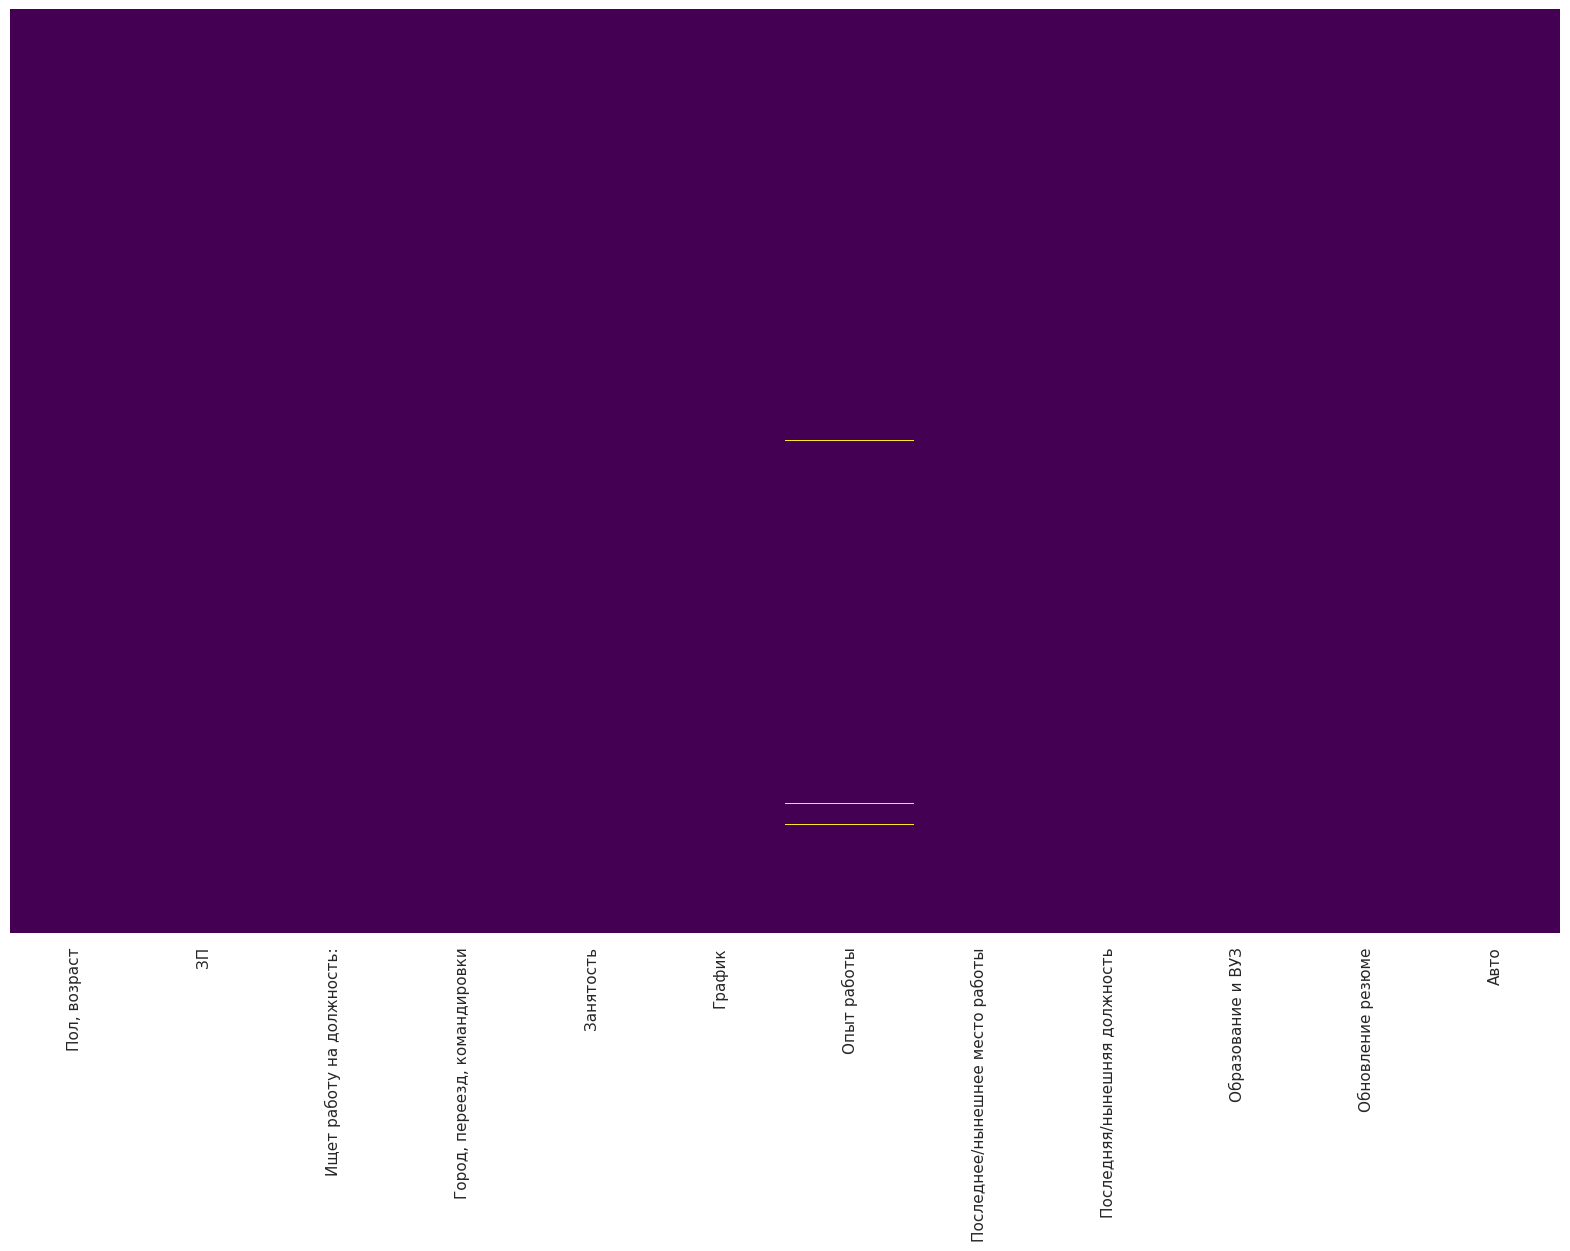

In [ ]:
# Визуализация таблицы на пропуски
fig, ax = plt.subplots(figsize=(20,12)) # Создаем область под график
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis') # Визуализируем прпуски
plt.show() # Отображаем график

## Так как в таблице присутствуют пропуски. Заменим это значения.

In [19]:
# Замена все NaN значения на текст.
df = df.fillna("Не указано")

## Удаление столбцов

Удаление не информативных столбцов

In [20]:
df = df.drop('Обновление резюме', axis=1)

# Удалять или нет этот столбец?
#df = df.drop('Последнее/нынешнее место работы', axis=1)
# df = df.drop('Последняя/нынешняя должность', axis=1)
df.shape

(44591, 11)

In [ ]:
df.head(1)

,"Пол, возраст",ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Авто
0,"Мужчина , 39 лет , родился 27 ноября 1979",29000 руб.,Системный администратор,"Советск (Калининградская область) , не готов к...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Опыт работы 16 лет 10 месяцев Август 2010 — п...,"МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Неоконченное высшее образование 2000 Балтийск...,Имеется собственный автомобиль


## Графики

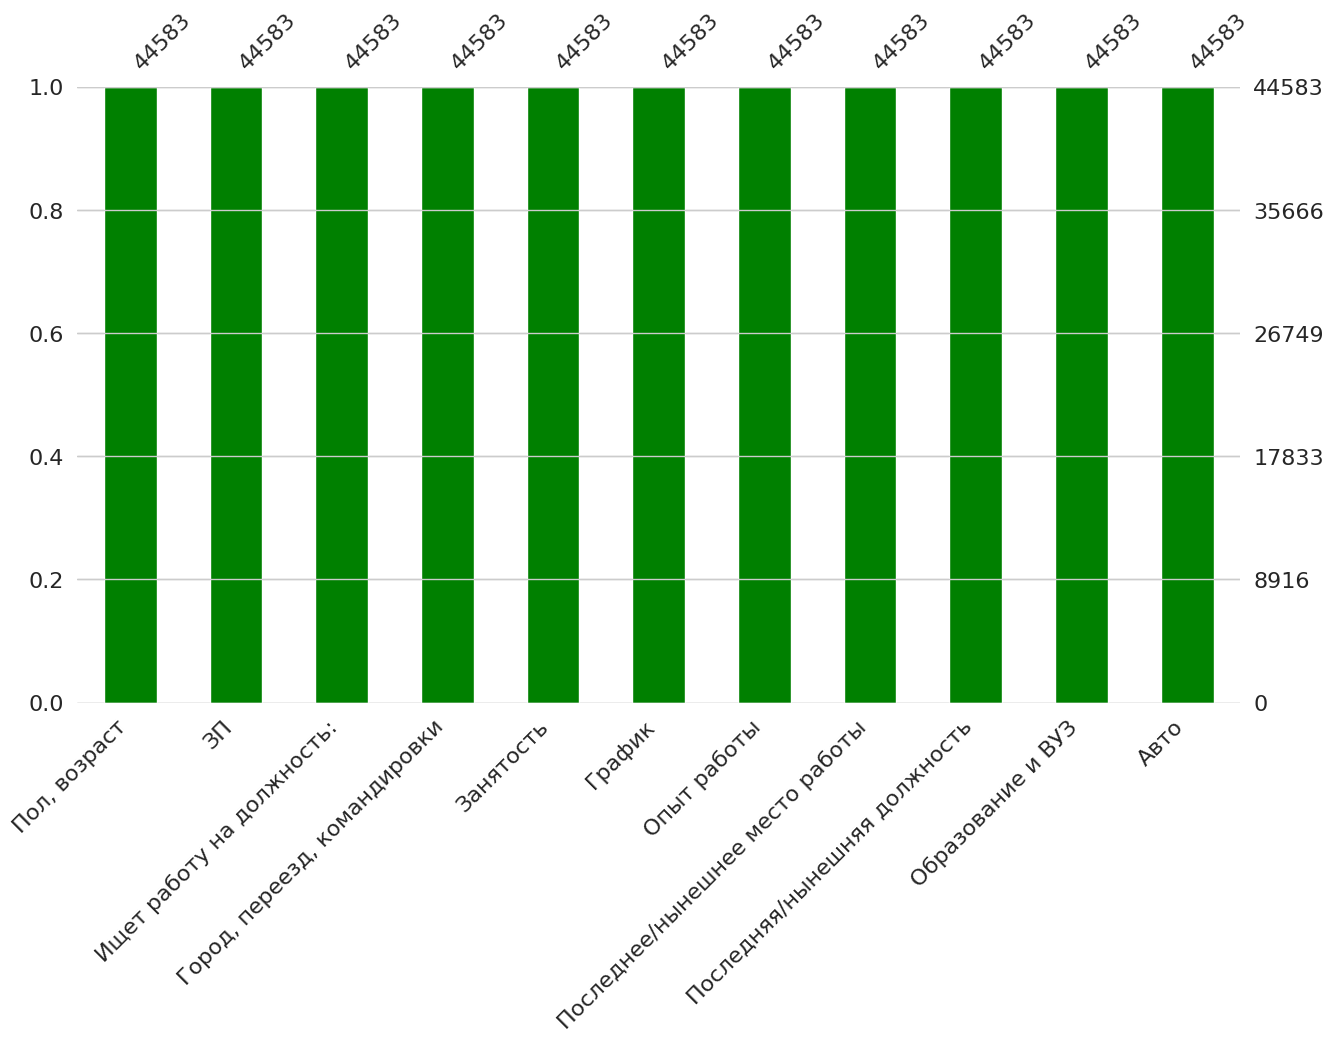

In [ ]:
msno.bar(df, figsize=(15,8), color="green");

# Парсинг базы





In [21]:
# Убрать кодировку в описаниях \xa0 \n
i=0
for j in range(df.shape[1]):  # Для каждого из столбцов таблицы
    for i in range(df.shape[0]): # По всем резюме
        if type(df.values[i][j])!=float: # если данные текстовые, то заменяем фрагменты кодировки ASCII на отсутствие символов
            df.values[i][j] = df.values[i][j].replace("\xa0","")
            df.values[i][j] = df.values[i][j].replace("\n"," ")

## Пол и возраст

In [ ]:
df.head(1)

,"Пол, возраст",ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Авто
0,"Мужчина , 39 лет , родился 27 ноября 1979",29000 руб.,Системный администратор,"Советск (Калининградская область) , не готов к...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Опыт работы 16 лет 10 месяцев Август 2010 — п...,"МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Неоконченное высшее образование 2000 Балтийск...,Имеется собственный автомобиль


In [ ]:
# Значения в столбце
df['Пол, возраст'].value_counts

<bound method IndexOpsMixin.value_counts of 0          Мужчина ,  39 лет , родился 27 ноября 1979
1           Мужчина ,  60 лет , родился 20 марта 1959
2        Женщина ,  36 лет , родилась 12 августа 1982
3            Мужчина ,  38 лет , родился 25 июня 1980
4           Женщина ,  26 лет , родилась 3 марта 1993
                             ...                     
44739      Мужчина ,  30 лет , родился 17 января 1989
44740        Мужчина ,  27 лет , родился 5 марта 1992
44741    Женщина ,  48 лет , родилась 26 декабря 1970
44742     Мужчина ,  24 года , родился 6 октября 1994
44743      Мужчина ,  38 лет , родился 25 апреля 1980
Name: Пол, возраст, Length: 44591, dtype: object>

In [22]:
# Из колонки: Пол, возраст - достаем пол и заносим в отдельный столбец
df['sex'] = df['Пол, возраст'].str.split(',').str[0].str.strip()

In [23]:
# Из колонки: Пол, возраст - достаем возраст и заносим в отдельный столбец
df['age'] = df['Пол, возраст'].apply(lambda x: re.search(r'\b\d+\b', x).group())

In [ ]:
df.head(1)

,"Пол, возраст",ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Образование и ВУЗ,Авто,sex,age
0,"Мужчина , 39 лет , родился 27 ноября 1979",29000 руб.,Системный администратор,"Советск (Калининградская область) , не готов к...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Опыт работы 16 лет 10 месяцев Август 2010 — п...,Неоконченное высшее образование 2000 Балтийск...,Имеется собственный автомобиль,Мужчина,39


In [24]:
# Удаляем не нужный столбец Пол, возраст
df.drop('Пол, возраст', axis=1, inplace=True)

## Колонка **зарплата**

In [ ]:
df.head(1)

,ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Авто,sex,age
0,29000 руб.,Системный администратор,"Советск (Калининградская область) , не готов к...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Опыт работы 16 лет 10 месяцев Август 2010 — п...,"МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Неоконченное высшее образование 2000 Балтийск...,Имеется собственный автомобиль,Мужчина,39


In [ ]:
df['ЗП'].unique

<bound method Series.unique of 0         29000 руб.
1         40000 руб.
2         20000 руб.
3        100000 руб.
4        140000 руб.
            ...     
44739     50000 руб.
44740     39000 руб.
44741     40000 руб.
44742     20000 руб.
44743    120000 руб.
Name: ЗП, Length: 44591, dtype: object>

In [ ]:
df['ЗП'].value_counts()

50000 руб.    4049
40000 руб.    3741
30000 руб.    3255
60000 руб.    3081
70000 руб.    2380
              ... 
36500 руб.       1
4860 USD         1
99 USD           1
150000 сум       1
259999 KZT       1
Name: ЗП, Length: 690, dtype: int64

Какие **валюты** присутствуют в колонке зарплаты

In [25]:
def extract_currency(value):
    # Используем метод isalpha для извлечения буквенных значений
    currency = ''.join(filter(str.isalpha, value))
    return currency

In [26]:
set(df['ЗП'].apply(extract_currency).unique())

{'AZN', 'EUR', 'KGS', 'KZT', 'USD', 'белруб', 'грн', 'руб', 'сум'}

Как видно в колонке с зарплатой присутствует зарплата в **иностранной** валюте.

In [27]:
# Резюме с зарплатой в иностранной валюте
filtered_rows = df.loc[~df['ЗП'].str.contains('руб.')]

In [28]:
# Общее число таких вакансий
total_count = len(filtered_rows)
print(f"Общее количество строк без 'руб.': {total_count}")

Общее количество строк без 'руб.': 1942


In [ ]:
# Резюме с зарплатой не в рублях
filtered_rows.head()

,ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Образование и ВУЗ,Авто,sex,age
81,160000 KZT,"Системный администратор, веб-программист","Алматы , м. Жибек Жолы , не готов к переезду ...",полная занятость,полный день,Опыт работы 1 год 11 месяцев Системный админи...,Неоконченное высшее образование 2018 Huaihua U...,Не указано,Мужчина,20
126,217000 KZT,"Программист, Инженер-системотехник, Водитель, ...","Актау , не готов к переезду , готов к редким к...",полная занятость,"гибкий график, полный день, вахтовый метод","Опыт работы 10 лет 10 месяцев Программист, Ин...",Высшее образование 2008 Каспийский государстве...,Не указано,Мужчина,32
145,2000 EUR,"Координатор проектов, редактор","Москва , м. Бульвар Рокоссовского , готова к ...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, удаленная работа",Опыт работы 13 лет 4 месяца Сентябрь 2011 — п...,Высшее образование 2009 Государственный униве...,Не указано,Женщина,33
147,5500 USD,"Разработчик ПО, аналитик, консультант","Пятигорск , готов к переезду (США, Австралия, ...","частичная занятость, полная занятость",удаленная работа,"Опыт работы 14 лет 7 месяцев Разработчик ПО, ...",Высшее образование 2004 Волгоградский государс...,Не указано,Мужчина,37
192,2000000 KZT,технический директор,"Алматы , готов к переезду (Беларусь, Кыргызста...","проектная работа, полная занятость","гибкий график, полный день, сменный график, ва...",Опыт работы 12 лет 1 месяц Февраль 2014 — по ...,Высшее образование (Магистр) 2010 Алматинский ...,Имеется собственный автомобиль,Мужчина,33


Так как таких резюме относительно не много можно их удалить

In [29]:
print(df.shape[0])
# Удаление резюме у которых зарплата не в рублях
df = df[df['ЗП'].str.contains('руб')]
print(df.shape[0])

44591
42649


In [30]:
# Оставим в колонке зарплаты только числовое значение
df['ЗП'] = df['ЗП'].apply(lambda x: re.search(r'\b\d+\b', x).group() if re.search(r'\b\d+\b', x) else None)
df['ЗП'] = pd.to_numeric(df['ЗП'], errors='coerce')

In [ ]:
df.head(2)

,ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Авто,sex,age
0,29000,Системный администратор,"Советск (Калининградская область) , не готов к...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Опыт работы 16 лет 10 месяцев Август 2010 — п...,"МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Неоконченное высшее образование 2000 Балтийск...,Имеется собственный автомобиль,Мужчина,39
1,40000,Технический писатель,"Королев , не готов к переезду , готов к редким...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...",Опыт работы 19 лет 5 месяцев Январь 2000 — по...,Временный трудовой коллектив,"Менеджер проекта, Аналитик, Технический писатель",Высшее образование 1981 Военно-космическая ак...,Не указано,Мужчина,60


## Город, переезд

In [ ]:
# Из колонки 'Город, переезд, командировки' - извлечем город

df['Город, переезд, командировки'].unique()

array(['Советск (Калининградская область) , не готов к переезду , не готов к командировкам',
       'Королев , не готов к переезду , готов к редким командировкам',
       'Тверь , не готова к переезду , не готова к командировкам', ...,
       'Октябрьский (Республика Башкортостан) , готов к переезду (Уфа, Альметьевск) , не готов к командировкам',
       'Москва ,  м. Площадь Ильича , готова к переезду (Москва) , готова к редким командировкам',
       'Новополоцк , готов к переезду , готов к командировкам'],
      dtype=object)

In [31]:
# Разбиваем значения в столбце по запятой
df['Город, переезд, командировки'] = df['Город, переезд, командировки'].apply(lambda x: x.split(','))

In [32]:
df['city'] = df['Город, переезд, командировки'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

In [ ]:
df.head()

,ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Авто,sex,age,city
0,29000,Системный администратор,"[Советск (Калининградская область) , не готов...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Опыт работы 16 лет 10 месяцев Август 2010 — п...,"МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Неоконченное высшее образование 2000 Балтийск...,Имеется собственный автомобиль,Мужчина,39,Советск (Калининградская область)
1,40000,Технический писатель,"[Королев , не готов к переезду , готов к ред...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...",Опыт работы 19 лет 5 месяцев Январь 2000 — по...,Временный трудовой коллектив,"Менеджер проекта, Аналитик, Технический писатель",Высшее образование 1981 Военно-космическая ак...,Не указано,Мужчина,60,Королев
2,20000,Оператор,"[Тверь , не готова к переезду , не готова к ...",полная занятость,полный день,Опыт работы 10 лет 3 месяца Октябрь 2004 — Де...,ПАО Сбербанк,Кассир-операционист,Среднее специальное образование 2002 Профессио...,Не указано,Женщина,36,Тверь
3,100000,Веб-разработчик (HTML / CSS / JS / PHP / базы ...,"[Саратов , не готов к переезду , готов к ред...","частичная занятость, проектная работа, полная ...","гибкий график, удаленная работа",Опыт работы 18 лет 9 месяцев Август 2017 — Ап...,OpenSoft,Инженер-программист,Высшее образование 2002 Саратовский государст...,Не указано,Мужчина,38,Саратов
4,140000,Региональный менеджер по продажам,"[Москва , не готова к переезду , готова к ко...",полная занятость,полный день,Опыт работы 5 лет 7 месяцев Региональный мене...,Мармелад,Менеджер по продажам,Высшее образование 2015 Кгу Психологии и педаг...,Не указано,Женщина,26,Москва


### Если не надо информация про переезд и командировки

In [33]:
df.drop('Город, переезд, командировки', axis=1, inplace=True)

## Занятость

In [ ]:
df['Занятость'].unique()

array(['частичная занятость, проектная работа, полная занятость',
       'полная занятость', 'частичная занятость, полная занятость',
       'частичная занятость',
       'стажировка, частичная занятость, проектная работа, полная занятость',
       'проектная работа, частичная занятость, полная занятость',
       'частичная занятость, проектная работа',
       'проектная работа, полная занятость',
       'стажировка, полная занятость',
       'стажировка, частичная занятость, проектная работа',
       'проектная работа, частичная занятость',
       'стажировка, частичная занятость, полная занятость',
       'стажировка, волонтерство, частичная занятость, проектная работа, полная занятость',
       'волонтерство, полная занятость', 'проектная работа',
       'проектная работа, волонтерство, полная занятость',
       'стажировка, проектная работа, полная занятость',
       'проектная работа, стажировка, частичная занятость, полная занятость',
       'проектная работа, стажировка, волонте

## Опыт работы

In [34]:
# Данные об опыте работы
def getParameterExperience(arg):
  arg = str(arg)
  #Проверяем, если не пустая строка
  symbols = 0
  years = 0
  months = 0
  for s in arg:
    if (s != " "):
      symbols += 1

  #Находим индексы пробелов около фразы "опыт работы"
  if (symbols > 10):
      spacesIndexes = []
      index = 0
      while ((len(spacesIndexes) < 5) & (index < len(arg))):
          if (arg[index] == " "):
              spacesIndexes.append(index)
          index += 1

      years = 0
      months = 0
      if (arg[spacesIndexes[2]+1] != "м"):
         if (len(spacesIndexes) >= 3):
            yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]] # Записываем в строку значение лет
            years = int(yearsStr)

         if (len(spacesIndexes) >= 5):
            monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]] # Записываем в строку значение месяцев
            if(arg[spacesIndexes[2]+1] == "м"):
                months = int(monthsStr)
      else:
        if (len(spacesIndexes) >= 3):
          monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
          months = int(monthsStr)

  return 12*years+months

In [35]:
df['required_experience'] = df['Опыт работы'].apply(getParameterExperience)

In [36]:
df.drop('Опыт работы', axis=1, inplace=True)

In [37]:
df.head(2)

,ЗП,Ищет работу на должность:,Занятость,График,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Авто,sex,age,city,required_experience
0,29000,Системный администратор,"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...","МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Неоконченное высшее образование 2000 Балтийск...,Имеется собственный автомобиль,Мужчина,39,Советск (Калининградская область),192
1,40000,Технический писатель,"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...",Временный трудовой коллектив,"Менеджер проекта, Аналитик, Технический писатель",Высшее образование 1981 Военно-космическая ак...,Не указано,Мужчина,60,Королев,228


## Образование

In [ ]:
df['Образование и ВУЗ'].value_counts()

Высшее образование 1987 Военный инженерный Краснознаменный институт им. А.Ф. Можайского факультет автоматизированных систем сбора и обработки информации, математическое обеспечение автоматизированных систем, инженер-математик                                                                 4
Высшее образование 2014  Московский технический университет связи и информатики, Москва Радио и телевидение, Средства связи с подвижными объектами                                                                                                                                                4
Высшее образование 2014 Тюменский Государственный Нефтегазовый Университет кафедра маркетинга и муниципального управления, Magistr магистратура 2012 Тюменский Государственный Нефтегазовый Университет кафедра маркетинга и муниципального управления, бакалавр                                  4
Высшее образование 2010  Московский государственный университет приборостроения и информатики, Москва Информатика и вычислит

In [38]:
def getParameterEducation(arg):
  if "Высшее" in arg or "Higher education" in arg:  return "Высшее"
  if "Среднее специальное" in arg:                  return "Среднее профессиональное"
  if "Неоконченное высшее" in arg:                  return "Незаконченное высшее"
  if "Среднее образование" in arg:                  return "Среднее"

  return "Не задано"

In [39]:
df['education'] = df['Образование и ВУЗ'].apply(getParameterEducation)

In [40]:
df.head()

,ЗП,Ищет работу на должность:,Занятость,График,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Авто,sex,age,city,required_experience,education
0,29000,Системный администратор,"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...","МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Неоконченное высшее образование 2000 Балтийск...,Имеется собственный автомобиль,Мужчина,39,Советск (Калининградская область),192,Незаконченное высшее
1,40000,Технический писатель,"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...",Временный трудовой коллектив,"Менеджер проекта, Аналитик, Технический писатель",Высшее образование 1981 Военно-космическая ак...,Не указано,Мужчина,60,Королев,228,Высшее
2,20000,Оператор,полная занятость,полный день,ПАО Сбербанк,Кассир-операционист,Среднее специальное образование 2002 Профессио...,Не указано,Женщина,36,Тверь,120,Среднее профессиональное
3,100000,Веб-разработчик (HTML / CSS / JS / PHP / базы ...,"частичная занятость, проектная работа, полная ...","гибкий график, удаленная работа",OpenSoft,Инженер-программист,Высшее образование 2002 Саратовский государст...,Не указано,Мужчина,38,Саратов,216,Высшее
4,140000,Региональный менеджер по продажам,полная занятость,полный день,Мармелад,Менеджер по продажам,Высшее образование 2015 Кгу Психологии и педаг...,Не указано,Женщина,26,Москва,60,Высшее


In [41]:
df.drop('Образование и ВУЗ', axis=1, inplace=True)

In [ ]:
df.head(2)

,ЗП,Ищет работу на должность:,Занятость,График,Последнее/нынешнее место работы,Последняя/нынешняя должность,Авто,sex,age,city,required_experience,education
0,29000,Системный администратор,"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...","МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Имеется собственный автомобиль,Мужчина,39,Советск (Калининградская область),192,Незаконченное высшее
1,40000,Технический писатель,"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...",Временный трудовой коллектив,"Менеджер проекта, Аналитик, Технический писатель",Не указано,Мужчина,60,Королев,228,Высшее


# Переименование столбцов как в таблице с вакансиями

In [42]:
df.columns = ['salary_min',
              'vacancy_name',
              'busy_type',
              'schedule_type',
              'place_work',
              'last_position',
              'required_drive_license',
              'sex',
              'age',
              'vacancy_address',
              'required_experience',
              'education']

df.head(2)

,salary_min,vacancy_name,busy_type,schedule_type,place_work,last_position,required_drive_license,sex,age,vacancy_address,required_experience,education
0,29000,Системный администратор,"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...","МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Имеется собственный автомобиль,Мужчина,39,Советск (Калининградская область),192,Незаконченное высшее
1,40000,Технический писатель,"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...",Временный трудовой коллектив,"Менеджер проекта, Аналитик, Технический писатель",Не указано,Мужчина,60,Королев,228,Высшее


## Поменять местами столбцы, чтобы был порядок как с вакансиями

In [43]:
df = df[['vacancy_name',
       'last_position',
       'place_work',
       'salary_min',
       'required_experience',
       'vacancy_address',
       'busy_type',
       'schedule_type',
       'education',
       'required_drive_license',
       'sex',
       'age']]


df.head(2)

,vacancy_name,last_position,place_work,salary_min,required_experience,vacancy_address,busy_type,schedule_type,education,required_drive_license,sex,age
0,Системный администратор,Системный администратор,"МАОУ ""СОШ № 1 г.Немана""",29000,192,Советск (Калининградская область),"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Незаконченное высшее,Имеется собственный автомобиль,Мужчина,39
1,Технический писатель,"Менеджер проекта, Аналитик, Технический писатель",Временный трудовой коллектив,40000,228,Королев,"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...",Высшее,Не указано,Мужчина,60


In [53]:
df.to_csv('resume_cleaned_16.12.csv', index=False)

# **2. EDA**

In [24]:
# Загрузка таблицы
df = pd.read_csv('/content/resume_cleaned_16.12.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,vacancy_name,last_position,place_work,salary_min,required_experience,vacancy_address,busy_type,schedule_type,education,required_drive_license,sex,age
0,Системный администратор,Системный администратор,"МАОУ ""СОШ № 1 г.Немана""",29000,192,Советск (Калининградская область),"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Незаконченное высшее,Имеется собственный автомобиль,Мужчина,39
1,Технический писатель,"Менеджер проекта, Аналитик, Технический писатель",Временный трудовой коллектив,40000,228,Королев,"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...",Высшее,Не указано,Мужчина,60
2,Оператор,Кассир-операционист,ПАО Сбербанк,20000,120,Тверь,полная занятость,полный день,Среднее профессиональное,Не указано,Женщина,36
3,Веб-разработчик (HTML / CSS / JS / PHP / базы ...,Инженер-программист,OpenSoft,100000,216,Саратов,"частичная занятость, проектная работа, полная ...","гибкий график, удаленная работа",Высшее,Не указано,Мужчина,38
4,Региональный менеджер по продажам,Менеджер по продажам,Мармелад,140000,60,Москва,полная занятость,полный день,Высшее,Не указано,Женщина,26


In [4]:
# Общий размер таблицы
print(df.shape)

(42649, 12)


## Общая информация

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42649 entries, 0 to 42648
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   vacancy_name            42649 non-null  object
 1   last_position           42649 non-null  object
 2   place_work              42649 non-null  object
 3   salary_min              42649 non-null  int64 
 4   required_experience     42649 non-null  int64 
 5   vacancy_address         42649 non-null  object
 6   busy_type               42649 non-null  object
 7   schedule_type           42649 non-null  object
 8   education               42649 non-null  object
 9   required_drive_license  42649 non-null  object
 10  sex                     42649 non-null  object
 11  age                     42649 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 3.9+ MB


In [58]:
# Описательная статистика по каждому столбцу
pd.set_option('display.float_format', lambda x:'%.3f'%x)
df.describe(include='all')

,vacancy_name,last_position,place_work,salary_min,required_experience,vacancy_address,busy_type,schedule_type,education,required_drive_license,sex,age
count,42649,42649,42649,42649.000,42649.000,42649,42649,42649,42649,42649,42649,42649.000
unique,14238,16167,28645,NaN,NaN,930,37,47,4,2,2,NaN
top,Системный администратор,Системный администратор,Индивидуальное предпринимательство / частная п...,NaN,NaN,Москва,полная занятость,полный день,Высшее,Не указано,Мужчина,NaN
freq,2982,1965,872,NaN,NaN,16390,28746,21736,32265,30709,34470,NaN
mean,NaN,NaN,NaN,75676.835,109.562,NaN,NaN,NaN,NaN,NaN,NaN,32.318
std,NaN,NaN,NaN,62942.870,79.209,NaN,NaN,NaN,NaN,NaN,NaN,7.954
min,NaN,NaN,NaN,1.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,14.000
25%,NaN,NaN,NaN,40000.000,48.000,NaN,NaN,NaN,NaN,NaN,NaN,27.000
50%,NaN,NaN,NaN,60000.000,96.000,NaN,NaN,NaN,NaN,NaN,NaN,31.000
75%,NaN,NaN,NaN,95000.000,144.000,NaN,NaN,NaN,NaN,NaN,NaN,36.000


## Кол-во пропусков

In [60]:
# Список всех столбцов
list_columns = list(df.columns)

In [61]:
for num, column in enumerate(list_columns):
  print(num, ': ', df[f'{column}'].isna().sum())

0 :  0
1 :  0
2 :  0
3 :  0
4 :  0
5 :  0
6 :  0
7 :  0
8 :  0
9 :  0
10 :  0
11 :  0


In [63]:
# Пример первой строчки с общим кол-вом пропусков
n = 0
for column_name, value in df.iloc[0].items():
    print(f"{n} : {column_name} - {value}")
    n += 1

0 : vacancy_name - Системный администратор
1 : last_position - Системный администратор
2 : place_work - МАОУ "СОШ № 1 г.Немана"
3 : salary_min - 29000
4 : required_experience - 192
5 : vacancy_address - Советск (Калининградская область) 
6 : busy_type - частичная занятость, проектная работа, полная занятость
7 : schedule_type - гибкий график, полный день, сменный график, вахтовый метод, удаленная работа
8 : education - Незаконченное высшее
9 : required_drive_license - Имеется собственный автомобиль
10 : sex - Мужчина
11 : age - 39


# **Корреляция данных**

## Посмотрим на разные графики корреляции

In [64]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,salary_min,required_experience,age
salary_min,1.000,0.275,0.207
required_experience,0.275,1.000,0.835
age,0.207,0.835,1.000


### Визуализация графика корреляции

<Axes: >

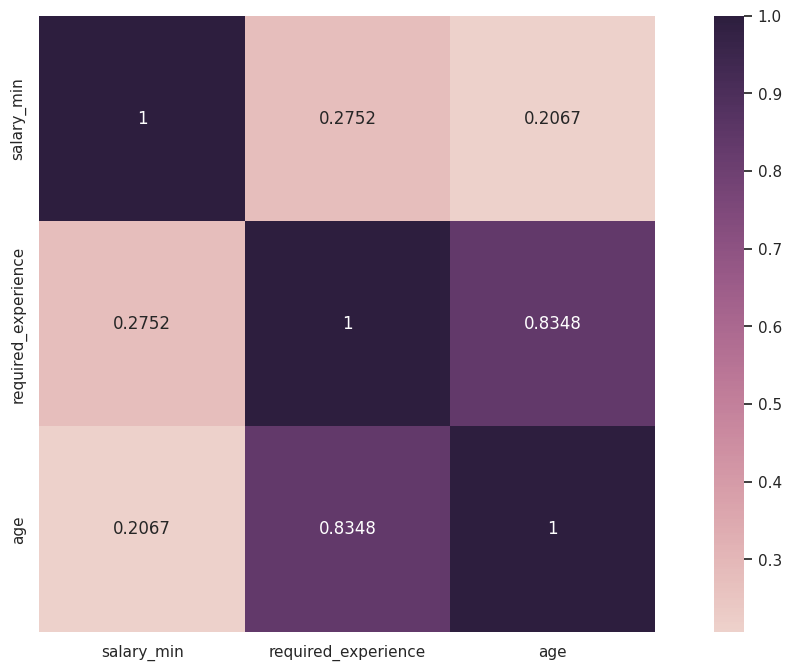

In [65]:
plt.subplots(figsize=(15,8))
fig=sns.heatmap(corr_matrix, annot=True, square=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='.4g')
fig

## **Графики**

### **Общие основные графики**

array([[<Axes: title={'center': 'salary_min'}>,
        <Axes: title={'center': 'required_experience'}>],
       [<Axes: title={'center': 'age'}>, <Axes: >]], dtype=object)

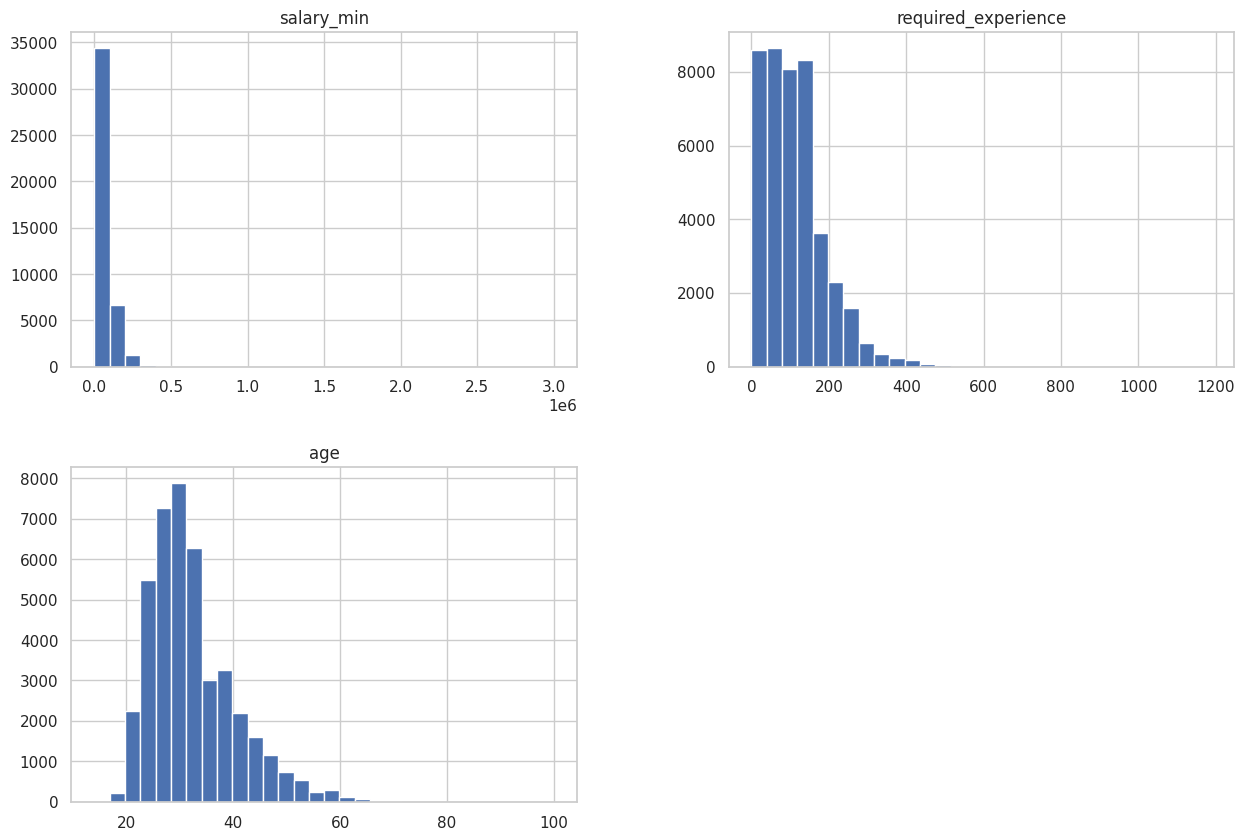

In [66]:
df.hist(bins=30, figsize=(15, 10))

# **Разбор каждого столбца**

In [73]:
df.head()

,vacancy_name,last_position,place_work,salary_min,required_experience,vacancy_address,busy_type,schedule_type,education,required_drive_license,sex,age
0,Системный администратор,Системный администратор,"МАОУ ""СОШ № 1 г.Немана""",29000,192,Советск (Калининградская область),"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Незаконченное высшее,Имеется собственный автомобиль,Мужчина,39
1,Технический писатель,"Менеджер проекта, Аналитик, Технический писатель",Временный трудовой коллектив,40000,228,Королев,"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...",Высшее,Не указано,Мужчина,60
2,Оператор,Кассир-операционист,ПАО Сбербанк,20000,120,Тверь,полная занятость,полный день,Среднее профессиональное,Не указано,Женщина,36
3,Веб-разработчик (HTML / CSS / JS / PHP / базы ...,Инженер-программист,OpenSoft,100000,216,Саратов,"частичная занятость, проектная работа, полная ...","гибкий график, удаленная работа",Высшее,Не указано,Мужчина,38
4,Региональный менеджер по продажам,Менеджер по продажам,Мармелад,140000,60,Москва,полная занятость,полный день,Высшее,Не указано,Женщина,26


## **1. Пол соискателя** - sex

In [74]:
df['sex'].describe()

count       42649
unique          2
top       Мужчина
freq        34470
Name: sex, dtype: object

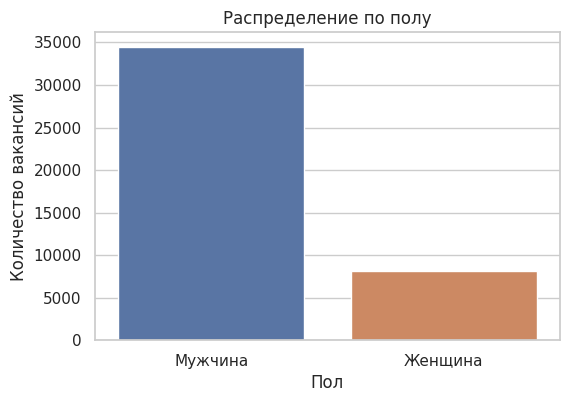

In [78]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=df)
plt.title('Распределение по полу')
plt.xlabel('Пол')
plt.ylabel('Количество вакансий')
plt.show()

**Вывод:**
Больше всего резюме мужского пола

### Связь между полом и зарплатой

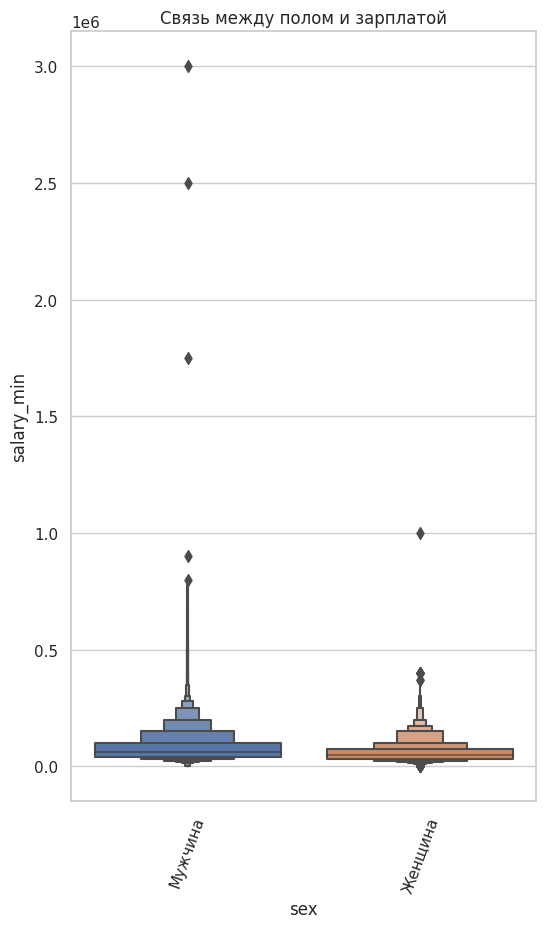

In [91]:
plt.figure(figsize=(6, 10))
sns.boxenplot(x='sex', y='salary_min', data=df)
plt.title('Связь между полом и зарплатой')
plt.xticks(rotation=70)
plt.show()

## 2. **Возраст - age**

In [83]:
df['age'].describe()

count    42649.000000
mean        32.318319
std          7.954182
min         14.000000
25%         27.000000
50%         31.000000
75%         36.000000
max        100.000000
Name: age, dtype: float64

Количество резюме по возрастам

In [84]:
df['age'].value_counts()

30     2681
29     2639
28     2600
31     2564
27     2448
       ... 
15        2
77        1
76        1
14        1
100       1
Name: age, Length: 63, dtype: int64

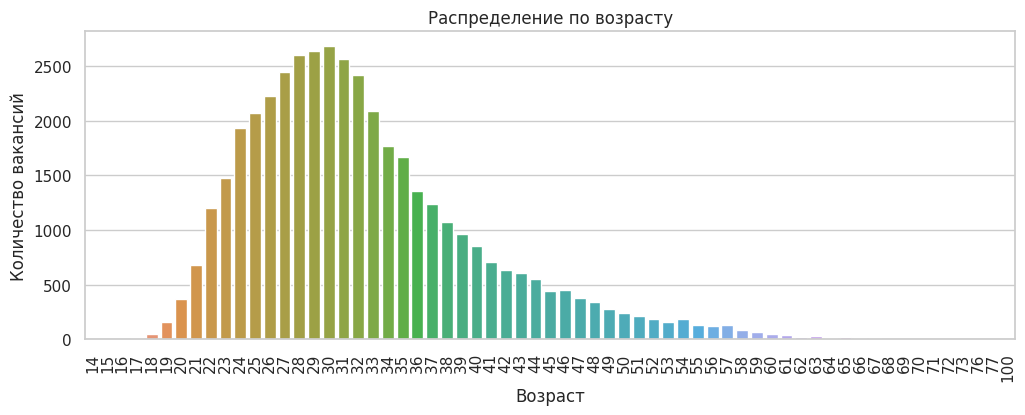

In [89]:
plt.figure(figsize=(12, 4))
sns.countplot(x='age', data=df)
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=90)
plt.show()

## 3. **Вакансии** - vacancy_name

In [67]:
df['vacancy_name'].describe()

count                       42649
unique                      14238
top       Системный администратор
freq                         2982
Name: vacancy_name, dtype: object

14238 - уникальных вакансий

In [68]:
df['vacancy_name'].value_counts()

Системный администратор                                    2982
Инженер                                                     939
Аналитик                                                    776
Менеджер проектов                                           719
Руководитель проекта                                        697
                                                           ... 
Старший специалист отдела разработки ПО                       1
Программист ORACLE, JAVA.                                     1
Оператор видеонаблюдения, специалист по видеонаблюдению       1
Web-программист/ QA engineer                                  1
Аналитик данных, Математик                                    1
Name: vacancy_name, Length: 14238, dtype: int64

### 30 самых популярный вакансий

In [25]:
# Посмотрим на 30 самых популярный вакансий
top30_profs = df['vacancy_name'].value_counts(dropna=False).nlargest(30)
top30_profs

Системный администратор               2982
Инженер                                939
Аналитик                               776
Менеджер проектов                      719
Руководитель проекта                   697
Специалист технической поддержки       680
Руководитель проектов                  658
Технический специалист                 480
Программист                            447
Менеджер проекта                       433
Менеджер интернет-магазина             432
Инженер-программист                    419
Специалист по IT                       398
Менеджер                               355
Оператор                               348
Специалист                             328
Сервисный инженер                      296
Интернет-маркетолог                    279
Региональный менеджер по продажам      277
Менеджер по продажам                   257
Инженер технической поддержки          254
Программист-разработчик                248
Помощник системного администратора     242
IT-специали

### Вакансии по **регионам**

In [72]:
df.groupby('vacancy_address', as_index=False).busy_type.count()

,vacancy_address,busy_type
0,Абакан,39
1,Абдулино,1
2,Абинск,1
3,Агой,1
4,Агрыз,2
...,...,...
925,Ярцево,2
926,Ясногорск,1
927,Ясный,1
928,Яхрома,3


### **Визуализация данных по вакансиям**

In [9]:
nlp = spacy.load("ru_core_news_sm")
russian_stopwords = stopwords.words('russian')

In [10]:
custom_position_lemmas = []
for i in tqdm(df['vacancy_name']):
    doc = nlp(str(i))
    lemmas = [token.lemma_ for token in doc if (token.text.isalpha() and token.text not in russian_stopwords)]
    custom_position_lemmas.extend(lemmas)

100%|██████████| 42649/42649 [07:13<00:00, 98.49it/s]


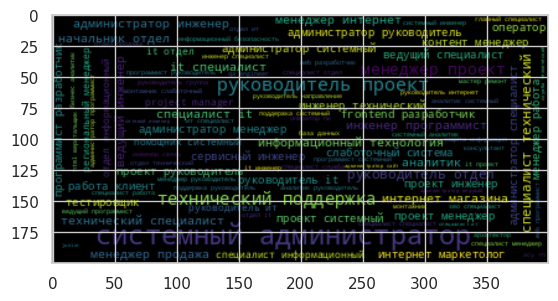

In [11]:
wordcloud = WordCloud(stopwords=russian_stopwords).generate(' '.join(custom_position_lemmas))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [12]:
c = Counter(custom_position_lemmas)
common_positions = dict(c.most_common(5))
common_positions_names = list(common_positions.keys())
common_positions_count = list(common_positions.values())

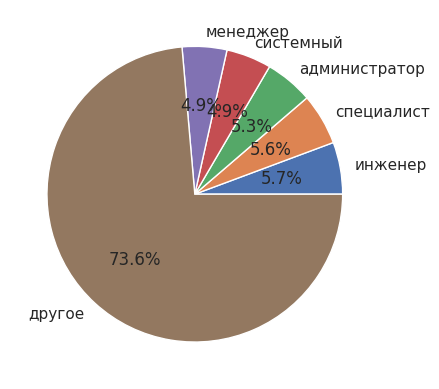

In [13]:
plt.pie(common_positions_count + [len(custom_position_lemmas) - sum(common_positions_count)],
        labels=common_positions_names + ['другое'],
        autopct='%1.1f%%')
plt.show()

## 4. **Зарплата** - salary_min

In [16]:
# Распределение зарплаты от
print(df['salary_min'].describe())


count    4.264900e+04
mean     7.567683e+04
std      6.294287e+04
min      1.000000e+00
25%      4.000000e+04
50%      6.000000e+04
75%      9.500000e+04
max      3.000000e+06
Name: salary_min, dtype: float64


In [17]:
# Самые большие зарплаты от
df[['vacancy_name','salary_min']].sort_values(by='salary_min', ascending=False).head(20)

,vacancy_name,salary_min
26971,"Руководитель IT проектов, Роботизация, Автомат...",3000000
41103,Chief AI Officer,2500000
39959,Project manager,1750000
30862,"Менеджер, Руководитель группы",1000000
15068,"Программист-разработчик 1C, PHP, 1C-Bitrix, C+...",900000
12092,Директор ИТ | Операционный Директор,800000
27290,Технический директор / Руководитель проектов,750000
33933,Директор ИТ / CIO,700000
18794,Директор технический,700000
11178,начальник отдела,700000


### Зарплата по ТОП 30 професиям

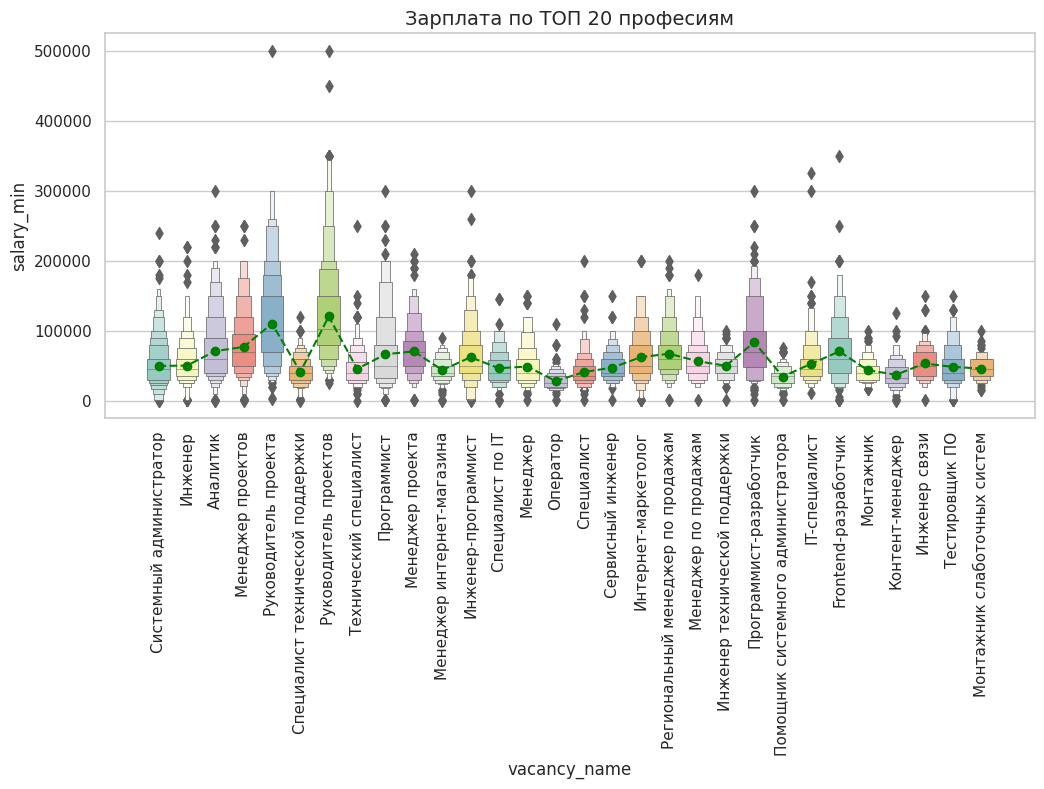

In [20]:
_df = df[df['vacancy_name'].isin(top30_profs.index)]
profession_ranking = list(top30_profs.index)

f, ax = plt.subplots(figsize=(12,5))
ax = sns.boxenplot(x="vacancy_name", y="salary_min",
              color="gray",  palette="Set3", order=profession_ranking,
              scale="linear", data=_df, linewidth=0.5)

ax.tick_params(axis='x', rotation=90)
ax.set_title("Зарплата по ТОП 20 професиям", fontsize=14)

means = _df.groupby("vacancy_name")["salary_min"].mean().loc[profession_ranking]
_ = plt.plot(range(len(profession_ranking)), means, marker="o", color="green", markersize=6, linestyle="--")

### **Средняя зарплата по городам**


In [27]:
grouped_df = df.groupby('vacancy_address')['salary_min'].mean()

# Выводим топ-10 городов с самыми большими зарплатами
for region_id, avg_salary in grouped_df.sort_values(ascending=False).head(10).items():
    print(f"{region_id}: {round(avg_salary)}")

# Выводим топ-10 городов с самыми маленькими зарплатами
print("\nТоп-10 регионов с самыми маленькими зарплатами:")
for region_id, avg_salary in grouped_df.sort_values(ascending=False).tail(10).items():
    print(f"{region_id}: {round(avg_salary)}")

Великобритания : 350000
США : 325000
Дания : 190000
Запрудня (Московская область) : 180000
Латвия : 180000
Куйбышевский Затон : 170000
Пангоды : 150000
Черноголовка : 146667
Алматы : 128000
Нур-Султан : 125000

Топ-10 регионов с самыми маленькими зарплатами:
Глуск : 800
Ганцевичи : 800
Молодечно : 700
Слоним : 700
Новополоцк : 688
Кобрин : 600
Лунинец : 500
Барановичи : 450
Жодино : 300
Дивногорск : 250


### **Взамосвязи между столбцами**

In [28]:
df.head(1)

,vacancy_name,last_position,place_work,salary_min,required_experience,vacancy_address,busy_type,schedule_type,education,required_drive_license,sex,age
0,Системный администратор,Системный администратор,"МАОУ ""СОШ № 1 г.Немана""",29000,192,Советск (Калининградская область),"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Незаконченное высшее,Имеется собственный автомобиль,Мужчина,39


#### График работы и зарплатой

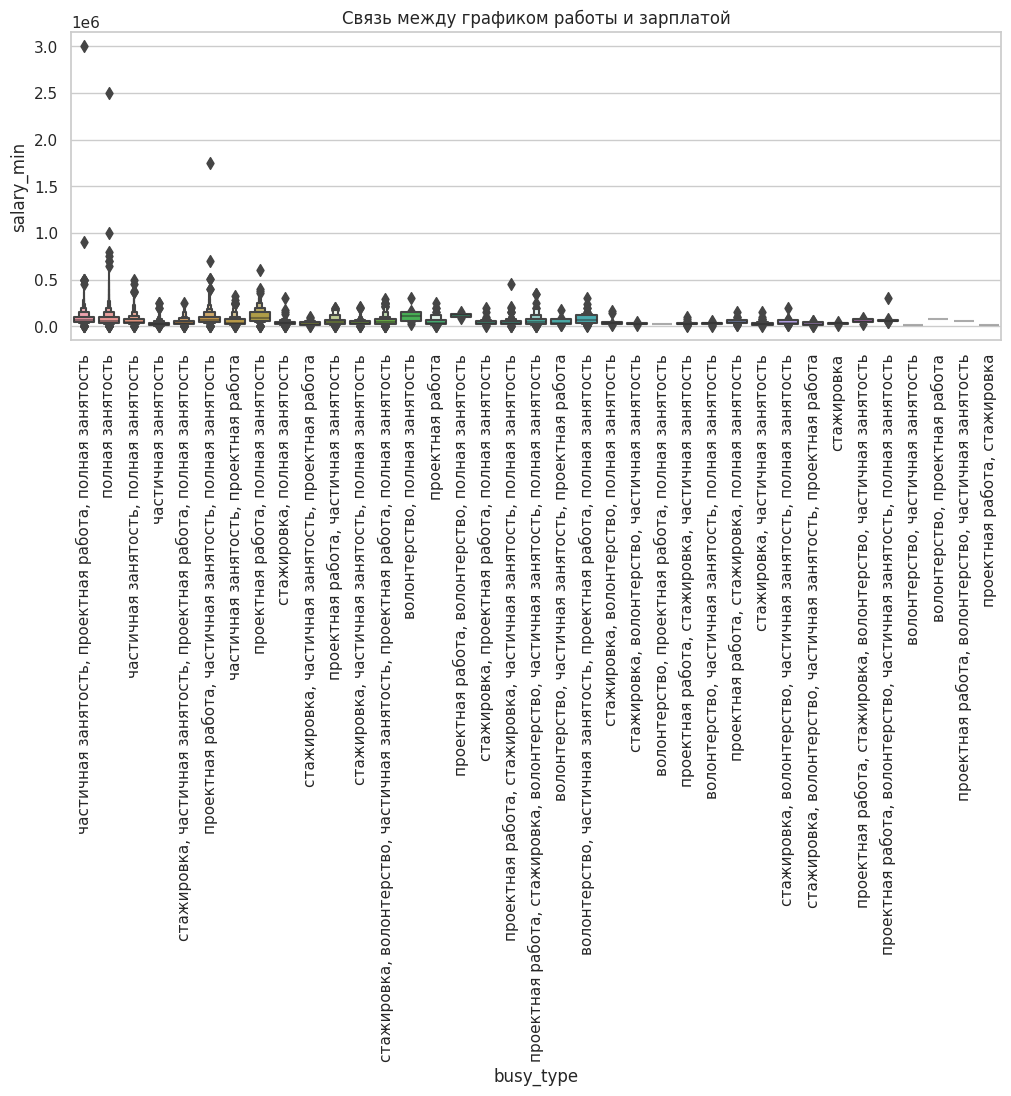

In [72]:
plt.figure(figsize=(12, 4))
sns.boxenplot(x='busy_type', y='salary_min', data=df)
plt.title('Связь между графиком работы и зарплатой')
plt.xticks(rotation=90)
plt.show()

## 5. **Тип занятости** - busy_type и schedule_type

In [31]:
df['busy_type'].value_counts()

полная занятость                                                                     28746
частичная занятость, полная занятость                                                 4628
частичная занятость, проектная работа, полная занятость                               3701
проектная работа, полная занятость                                                     914
стажировка, частичная занятость, проектная работа, полная занятость                    845
проектная работа, частичная занятость, полная занятость                                725
частичная занятость                                                                    610
стажировка, частичная занятость, полная занятость                                      592
частичная занятость, проектная работа                                                  466
стажировка, полная занятость                                                           424
стажировка, волонтерство, частичная занятость, проектная работа, полная занятость      243

In [32]:
df['schedule_type'].value_counts()

полный день                                                                     21736
гибкий график, полный день, сменный график, удаленная работа                     3838
гибкий график, полный день, удаленная работа                                     2499
гибкий график, полный день, сменный график                                       2194
полный день, сменный график                                                      1782
полный день, удаленная работа                                                    1546
гибкий график, полный день, сменный график, вахтовый метод, удаленная работа     1408
гибкий график, полный день                                                       1402
удаленная работа                                                                 1057
удаленная работа, гибкий график, полный день, сменный график                      743
гибкий график, удаленная работа                                                   650
удаленная работа, гибкий график, полный день          

### Графики

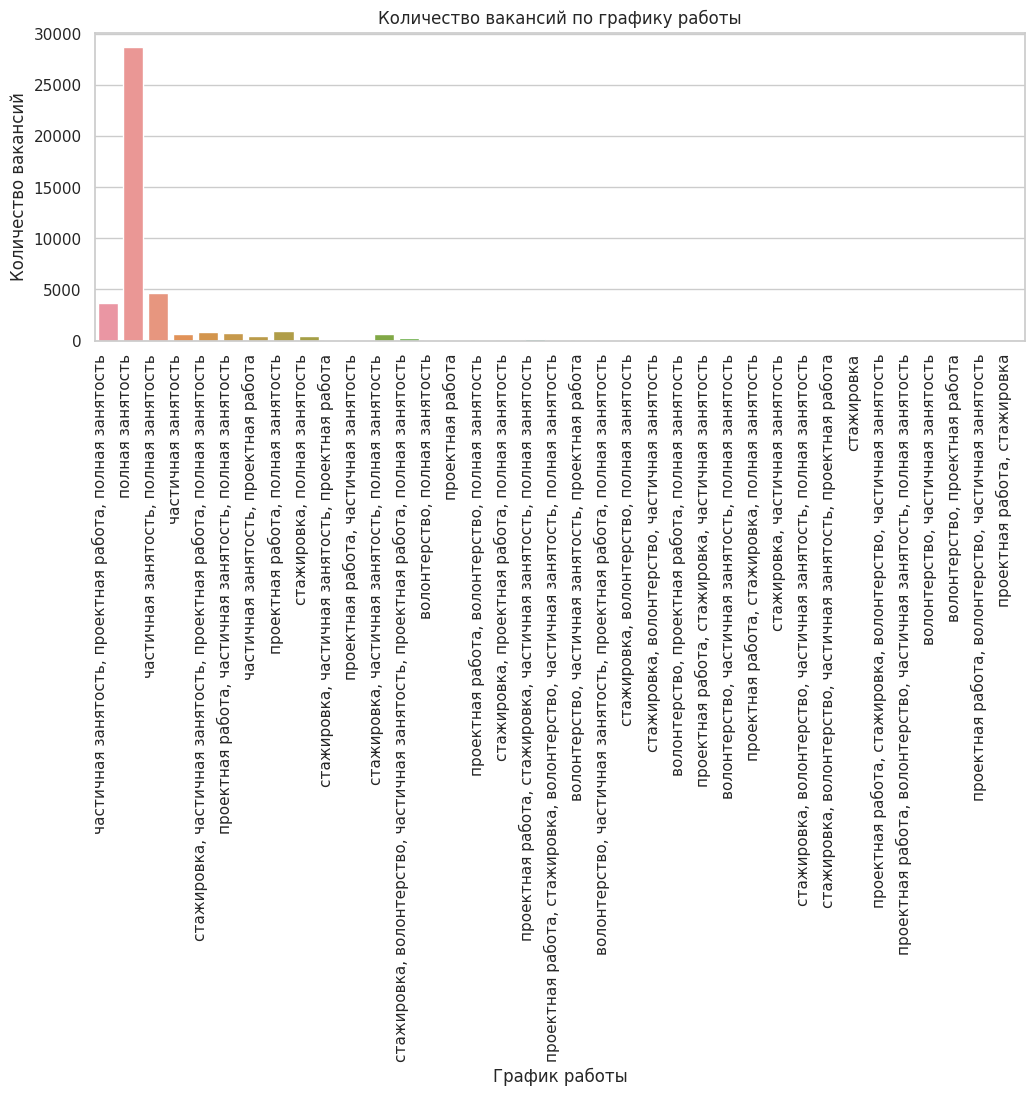

In [71]:
plt.figure(figsize=(12, 4))
sns.countplot(x='busy_type', data=df)
plt.title('Количество вакансий по графику работы')
plt.xlabel('График работы')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=90, ha='right')
plt.show()

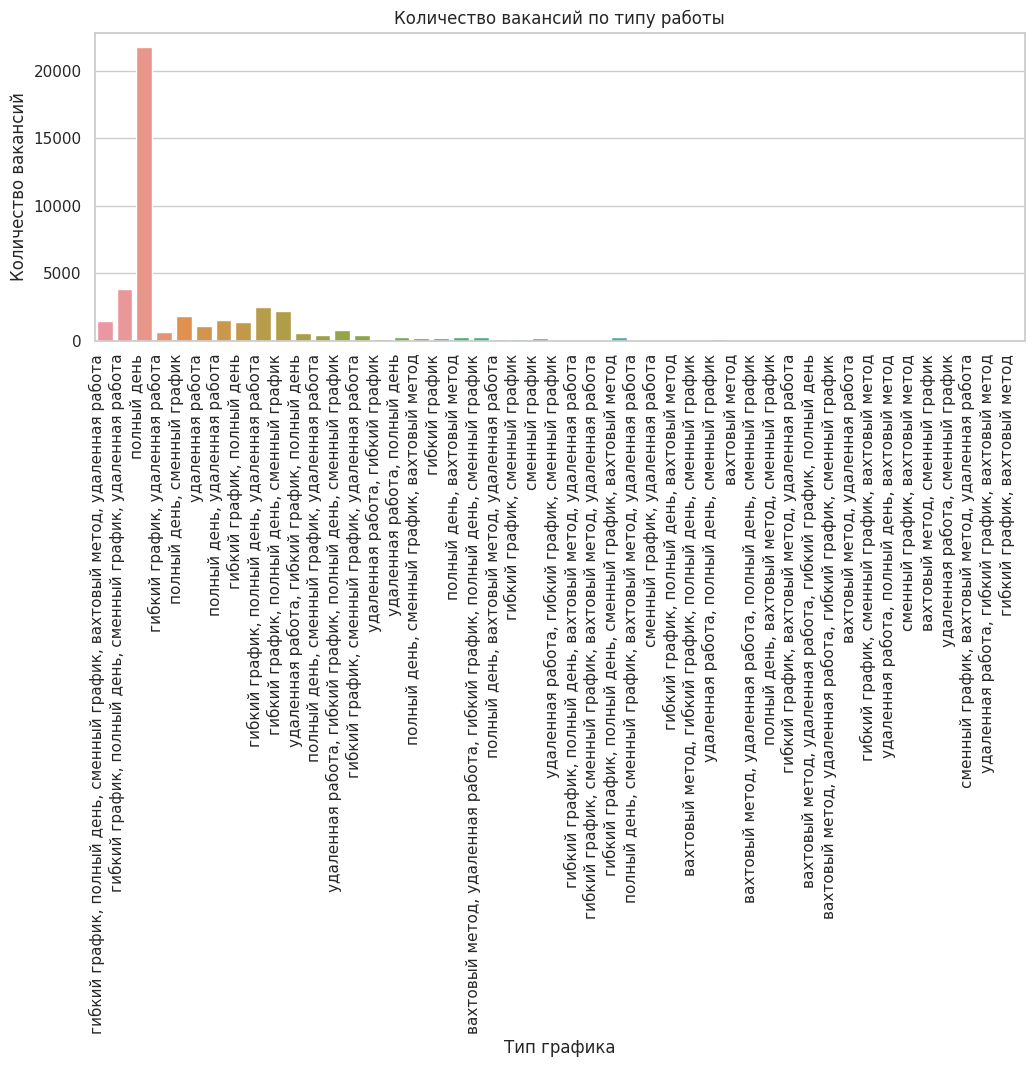

In [70]:
plt.figure(figsize=(12, 4))
sns.countplot(x='schedule_type', data=df)
plt.title('Количество вакансий по типу работы')
plt.xlabel('Тип графика')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=90, ha='right')
plt.show()

### **Вывод:**
 - Больше всего вакансий с полным рабочим днем. На втором месте - частичная занятость.

## 6. **Уровень образования** - education

In [39]:
df['education'].value_counts()

Высшее                      32265
Среднее профессиональное     5474
Незаконченное высшее         4382
Среднее                       528
Name: education, dtype: int64

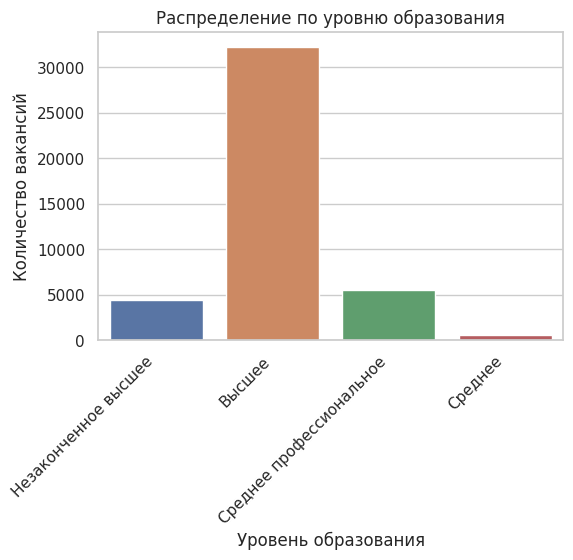

In [40]:
plt.figure(figsize=(6, 4))
sns.countplot(x='education', data=df)
plt.title('Распределение по уровню образования')
plt.xlabel('Уровень образования')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=45, ha='right')
plt.show()

### **Вывод:**
Как видно большинство резюме с высшим образованием


### Связь между образованием и зарплатой

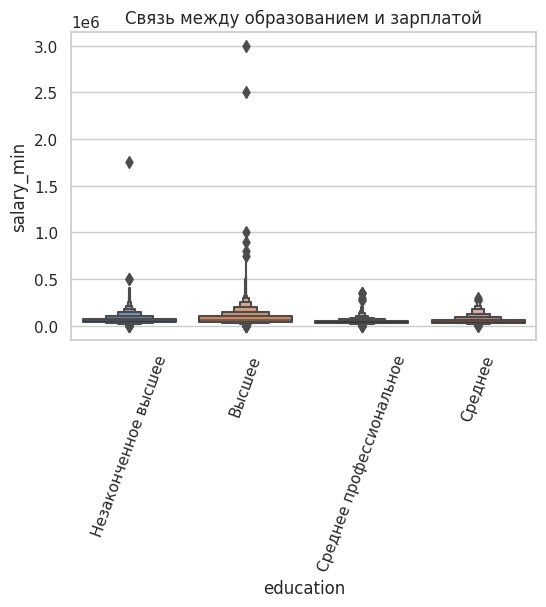

In [41]:
plt.figure(figsize=(6, 4))
sns.boxenplot(x='education', y='salary_min', data=df)
plt.title('Связь между образованием и зарплатой')
plt.xticks(rotation=70)
plt.show()

## 7. **Регионы** - regionName

In [44]:
df.head(1)

,vacancy_name,last_position,place_work,salary_min,required_experience,vacancy_address,busy_type,schedule_type,education,required_drive_license,sex,age
0,Системный администратор,Системный администратор,"МАОУ ""СОШ № 1 г.Немана""",29000,192,Советск (Калининградская область),"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Незаконченное высшее,Имеется собственный автомобиль,Мужчина,39


In [45]:
region_counts = df['vacancy_address'].value_counts()
print(region_counts)

Москва                                   16390
Санкт-Петербург                           4865
Краснодар                                 1048
Новосибирск                                946
Казань                                     853
                                         ...  
Красноперекопск                              1
Краснослободск (Республика Мордовия)         1
Холмск                                       1
Магас                                        1
Темрюк                                       1
Name: vacancy_address, Length: 930, dtype: int64


### Количество уникальных регионов

In [46]:
print(f'Количество уникальных регионов: {len(df["vacancy_address"].unique())}')

Количество уникальных регионов: 930


In [53]:
# Определяем порог для подписей (0.5% от общего количества)
threshold = 0.005 * len(df)

# Отбираем только те значения, где количество больше порога
annotated_region_ids = region_counts[region_counts > threshold].index

filtered_data = df[df['vacancy_address'].isin(annotated_region_ids)]

print(f'Процент данных, который занимают следующие регионы:\n{list(annotated_region_ids)}\nРавен {round(len(filtered_data)/len(df)*100)}%')

Процент данных, который занимают следующие регионы:
['Москва ', 'Санкт-Петербург ', 'Краснодар ', 'Новосибирск ', 'Казань ', 'Екатеринбург ', 'Самара ', 'Ростов-на-Дону ', 'Нижний Новгород ', 'Уфа ', 'Воронеж ', 'Пермь ', 'Красноярск ', 'Тюмень ', 'Челябинск ', 'Омск ', 'Томск ', 'Ярославль ', 'Волгоград ', 'Саратов ', 'Минск ']
Равен 73%


### **График**

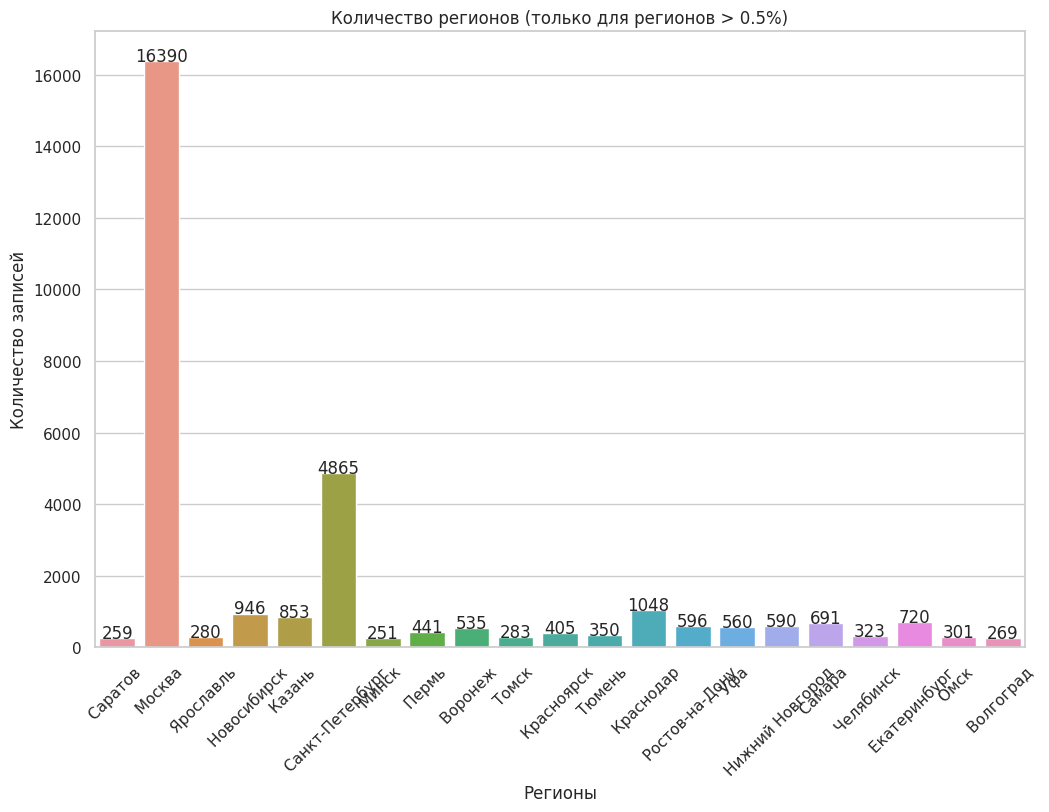

In [54]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='vacancy_address', data=filtered_data)
plt.title('Количество регионов (только для регионов > 0.5%)')
plt.xlabel('Регионы')
plt.ylabel('Количество записей')

for p in ax.patches:
    if p.get_height() > threshold:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.xticks(rotation=45)
plt.show()

**Вывод:**
Больше всего резюме из Москвы.

## 8. **Должности** - position_requirements

In [58]:
# Для начала надо заменить все NaN значения на текст. Например
df['last_position'] = df['last_position']

In [59]:
# Вывод нескольких ячеек для просмотра
for i in df['last_position'][:5]:
  print(i)
  print()

Системный администратор

Менеджер проекта, Аналитик, Технический писатель

Кассир-операционист

Инженер-программист

Менеджер по продажам



## 9. **Опыт** - required_experience

In [60]:
# Распределение зарплаты от
print(df['required_experience'].unique())


[ 192  228  120  216   60  108  264   36   96  132  504  156   72   12
  180   48  144  168   84  324   24  204  300    0  360   10    6  312
  288  468    3   11    9  240  252  396    4    7    2  432    5  276
  408  384  372    8  348  444    1  336  492  420  480  456  660  516
  540  528  648  564  552  576 1188  612]


### Количество вакансий в зависимости от опыта

In [62]:
df['required_experience'].value_counts()

72      3061
84      3018
60      2888
96      2769
48      2705
        ... 
576        2
660        1
648        1
1188       1
612        1
Name: required_experience, Length: 64, dtype: int64

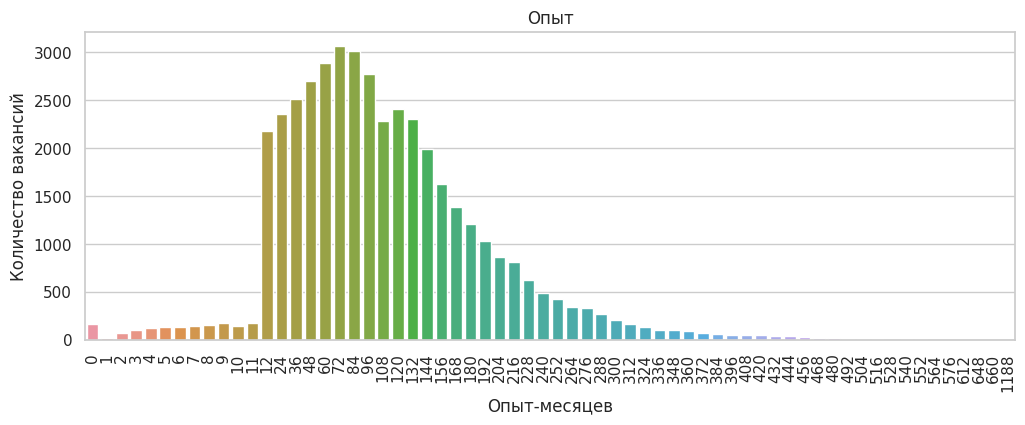

In [66]:
plt.figure(figsize=(12, 4))
sns.countplot(x='required_experience', data=df)
plt.title('Опыт')
plt.xlabel('Опыт-месяцев')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=90)
plt.show()

### Связь между опытом и зарплатой

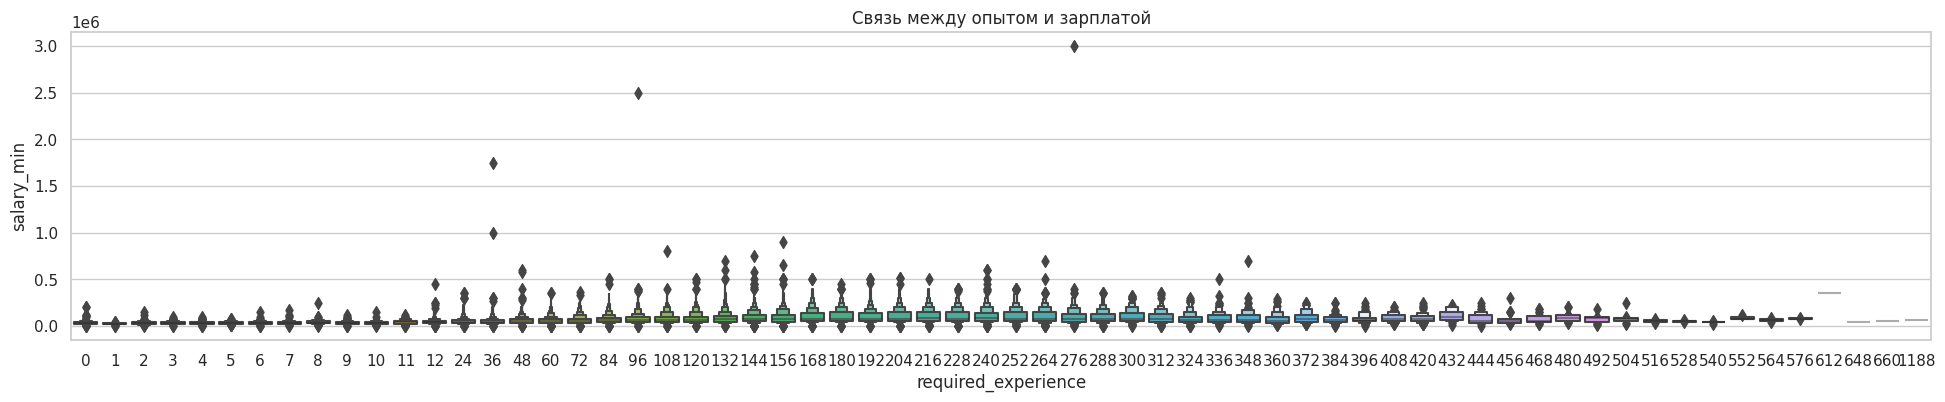

In [69]:
plt.figure(figsize=(24, 4))
sns.boxenplot(x='required_experience', y='salary_min', data=df)
plt.title('Связь между опытом и зарплатой')
plt.show()

In [57]:
df.head(1)

,vacancy_name,last_position,place_work,salary_min,required_experience,vacancy_address,busy_type,schedule_type,education,required_drive_license,sex,age
0,Системный администратор,Системный администратор,"МАОУ ""СОШ № 1 г.Немана""",29000,192,Советск (Калининградская область),"частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Незаконченное высшее,Имеется собственный автомобиль,Мужчина,39
